# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
#for i in range(1, 6):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
env_info = env.reset(train_mode=True)[brain_name]

In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import copy
from collections import namedtuple, deque

In [9]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=256, fc3_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.tanh(self.fc4(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256,  fc3_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [10]:
BUFFER_SIZE = int(1e3)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, replay_buffer, actor_local, actor_target, critic_local, critic_target):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        #self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        #self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_local  = actor_local
        self.actor_target = actor_target
                 
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        #self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        #self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_local = critic_local
        self.critic_target = critic_target
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        #self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.memory = replay_buffer
    
    def step(self, states, actions, rewards, next_states, dones, time):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        #    self.memory.add(state, action, reward, next_state, done)
        self.memory.add(states, actions, rewards, next_states, dones)

        # Learn, if enough samples are available in memory
        #if time % 5 == 0:
        if len(self.memory) > BATCH_SIZE:
            for i in range(2):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        #action[0] = np.clip(action[0], -1, 1)
        #action[1] = np.clip(action[1], -1, 1)
        return np.clip(action, -10, 10)
        #return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [11]:
import gym
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
random_seed = 0

#replay_buffer_0 = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
#agent_0 = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, replay_buffer=replay_buffer_0)
print(action_size)
common_replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
common_actor_local   = Actor(state_size, action_size, random_seed).to(device)
common_actor_target  = Actor(state_size, action_size, random_seed).to(device)

common_critic_local  = Critic(state_size, action_size, random_seed).to(device)
common_critic_target = Critic(state_size, action_size, random_seed).to(device)

agents = [Agent(state_size=state_size, action_size=action_size,
                random_seed=random_seed, replay_buffer=common_replay_buffer,
                actor_local=common_actor_local, actor_target=common_actor_target,
                critic_local=common_critic_local, critic_target=common_critic_target
               ) for x in range(num_agents)]

2


In [13]:
def save_model(agent, name):
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(name))
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_{}.pth'.format(name))

def ddpg(n_episodes=3000, max_t=300, print_every=25):
    scores_deque = deque(maxlen=print_every)
    scores = []
    average_scores = []
    episode_number = 0
    max_score = 0
    no_change_in_max_score_count = 0
    achieved_threshold = False
    try:
        for i_episode in range(1, n_episodes+1):
            episode_number = i_episode
            env_info = env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations
            score_agents = [0 for agent in agents]
            for agent in agents:
                agent.reset()
            
            for t in range(max_t):
                actions = [agent.act(state) for agent,state in zip(agents,states)]
                env_info = env.step(actions)[brain_name]
                time.sleep(0.1)
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                #next_state, reward, done, _ = env.step(action)[brain_name]
                for agent,state, action, reward, next_state, done in zip(agents, states, actions, rewards, next_states, dones):
                    agent.step(state, action, reward, next_state, done, t)
            
                states = next_states
            
                for score, reward in zip(score_agents, rewards):
                    score += np.sum(reward)
            
                if np.any(dones):
                    break 
                    
            prev_max_score = max_score
            max_score = np.amax(score)
            if(prev_max_score == max_score):
                no_change_in_max_score_count = no_change_in_max_score_count + 1
            else:
                no_change_in_max_score_count = 0
            
            scores_deque.append(max_score)
            scores.append(max_score)        
            average_score = np.mean(scores_deque)
            average_scores.append(average_score)
            
            update_string = '\rEpisode {}\tAverage Score: {:.3f}'
            print(update_string.format(i_episode, average_score), end="")
            
            if i_episode % print_every == 0:
                if (achieved_threshold == False):
                    [save_model(agent, i) for i, agent in enumerate(agents)]
                print(update_string.format(i_episode, np.mean(scores_deque)))
            
            if average_score >= 0.5:
                achieved_threshold = True
                [save_model(agent, i) for i, agent in enumerate(agents)]
                #torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                #torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
                print('\rAverage score reached 0.5 at Episode {}'.format(i_episode))
                
            if no_change_in_max_score_count >= 100:
                print('\rNo change in max score detected for {} episodes, ending run'.format(no_change_in_max_score_count))
                break
    except KeyboardInterrupt:
        print('\nDetected Keyboard interrupt, returning after episide {}'.format(episode_number))
        return scores, average_scores
            
            
    return scores, average_scores

In [14]:
scores, average_scores = ddpg()

Episode 4	Average Score: -0.005

/home/anoop/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:106: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 25	Average Score: -0.005
Episode 27	Average Score: -0.005
Detected Keyboard interrupt, returning after episide 28


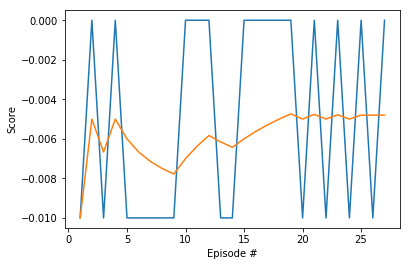

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), average_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()